# Twitter Sentiment Analysis

## Preparing

Installing and importing packages.

In [1]:
!pip install wordcloud
!pip install unidecode

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adriantt727/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from sklearn.feature_extraction.text import CountVectorizer        
from nltk.stem.porter import PorterStemmer

import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
import re
import unidecode

import string
from string import digits

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

#to show plots inline in notebooks
%matplotlib inline

I will work with the "classified" tweets first in preparation for the model.

# Data Cleaning - Classified Tweets

Read the classified tweets and save them to a data frame to prepare for text cleaning (later I found out executing cleaning operations on a dataframe is actually very slow, so when I clean the unclassfied tweets, I will use a different approach - read everything into one single string directly and break them up to individual tweets after cleanning.

In [5]:
#read file and save lines to a list
classified_tweets_data = []
with open('classified_tweets.txt', 'r') as classified_tweets_file:
    for line in classified_tweets_file:
        classified_tweets_data.append(line)

In [6]:
#extract each element in classified_tweets_data and get the text inside the double quotations 
#and then save it to a list
data_list =[]
for items in classified_tweets_data:
    data_list.append((re.findall(r'"([^"]*)"', items)))

#create a dictionary for which the elements of the first list of aa become keys and each key's values are taken
#from remaining lists's corresponding elements    
keys = data_list[0] #the first list element of the data_list list contains our keys or column names
values = data_list[1:]
#map the values to keys to form a dictionary
data_dic = {x:list(y) for x,y in zip(keys, zip(*values))}
#form a dataframe from the dictionary and rearrange the sequance of each column
df_classified = pd.DataFrame(data_dic, columns=['class', 'id', 'date', 'query', 'user', 'text'])

In [7]:
#display the first 5 rows of the classfied tweets dataframe
df_classified.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


I used the supplied stop_words file to create a list of stop_words instead of using NLTK's English set. I did not add any other stopwords to the list.

In [8]:
#read the provided stop_words.txt file and save its elements in a list as the stop words used here
stop_words = []
with open('stop_words.txt', 'r') as stopwords_file:
    for lines in stopwords_file:
        stop_words.append(lines.strip())

#define my function to use the stop words list to remove stopwords of the classfied tweets
def remove_stopwords(tweet_text):
    
    #split the text string word by word and put them in a list        
    tweet_text_splited = tweet_text.split(' ')
    #strip away all the stop words
    resultwords  = [word for word in tweet_text_splited if word not in stop_words]
    #put remaining words back together into a text string
    tweet_text_stopwords_removed = ' '.join(resultwords)
    
    return tweet_text_stopwords_removed


#define my cleanning function contains a series of cleaning operations for the classfied tweets
def clean(df):
    
    copy_df = df.copy()
    
    for i,tweet in enumerate(copy_df.text):
        #remove html tags and attributes
        temp = re.sub(r'<[^>]+>','', tweet)
    
        #convert all non-ASCII characters to their closest ASCII equivalent 
        temp = unidecode.unidecode(temp)
    
        #remove URL
        temp = re.sub(r'[a-z]*[:.]+\S+', '', temp)
    
        #remove @username strings
        temp = re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)', '', temp)
    
        #remove all punctuations
        translator = str.maketrans('', '', string.punctuation)
        temp = temp.translate(translator)

        #remove all digits
        remove_digits = str.maketrans('', '', digits)
        temp = temp.translate(remove_digits)
    
        #convert everything in text to lowercase
        temp = temp.lower()
        
        #remove stop words
        temp = remove_stopwords(temp)
        
        #update each row for the tweets
        copy_df.text[i] = temp
    
    return copy_df

## WARNING!!! 
As I previously mentioned, executing the cleaning function on such a hugh data frame is very slow so please be advised that if you run the next line of code, it would take about 10 minutes or so.

In [9]:
#clean the classfied tweet texts
df_classified_cleaned = clean(df_classified)

In [10]:
#displace the first 5 rows of cleaned data
df_classified_cleaned.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda david carr third day
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cant update facebook texting cry result...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived times ball managed save rest bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,body feels itchy fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad cant


## Exploratory Analysis Plot - Classified Tweet
I will do a WordCloud for the classified tweets.

In [15]:
#cast the tweets to strings in a pandas series
df_classified_cleaned_str = df_classified_cleaned['text'].astype(str)

#put each tweet string into a list
st_list = []
for item in df_classified_cleaned_str:
    st_list.append(item)

#join all strings in the list to one whole string to be used for the Wordcloud    
text_string = ''.join(st_list)

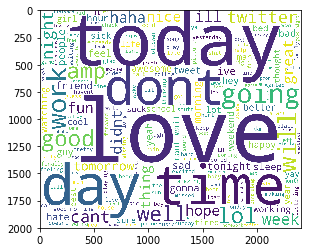

In [16]:
#generate the wordcloud with the string contains all the cleaned tweets
wordcloud = WordCloud(background_color='white', width=2400, height=2000).generate(text_string)

plt.imshow(wordcloud)
plt.axis('on')
plt.show()

# Model Preparation

Now with the classified tweets are cleaned and each tweet has a sentiment value, I can start to build the regression model.

In [17]:
#the tokenize function will be used as the tokenizer for CountVectorizer.
#the tokenize function also uses a stem_tokens function to apply a stemmer.
#a stemmer is to remove the commoner morphological and inflexional endings from words in English.
#For example the word ‘running’ will become ‘run’ so we won’t count ‘running’ and ‘run’ separately in our dataset.
#It may improve the accuracy of our classifier.

stemmer = PorterStemmer()

#defin a stemmer function
def stem_tokens(tokens, stemmer):
    
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
        
    return stemmed

#define a tokenizer function
def tokenize(text):
    
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    
    return stems

Tuning the "max_features" to get a better predictive precision. If leave this number unspecified, my computer would run out of memory. When max_features was tuned from 150 to 2000, the model precision has jumped from as low as 66% up to 71%, and when set to 3000 it only gets to current 73% so this is the optimal value that my model could have.

In [18]:
#initiate vectorizer that will be used to store the 3000 features
vectorizer = CountVectorizer(analyzer = 'word', tokenizer = tokenize, max_features = 3000)

In [19]:
#fit and transform the model using the vectorizer by extracting 3000 features from all classified tweets
#so the feature matrix is 200000 by 3000
corpus_data_features = vectorizer.fit_transform(df_classified_cleaned.text.tolist())

In [20]:
#convert the feature vectors set to a nd array for easy-handeling
#again the array has 200000 elements corresponding to the number of tweets
#and each element has 3000 entries corresponding to each feature
#if the feature exists for the tweet then it is 1 otherwise it is 0
corpus_data_features_nd = corpus_data_features.toarray()

In [21]:
#split the classifled tweets data set to 70% of training set and 30% of test set
#x is the corpus_data_features_nd and y is the sentiment values of the classified tweets
X_train, X_test, y_train, y_test  = train_test_split(
        corpus_data_features_nd, 
        df_classified_cleaned['class'],
        train_size=0.70)

In [22]:
#train the model using the training set
log_model = LogisticRegression()
log_model = log_model.fit(X=X_train, y=y_train)

In [23]:
#predict the sentiment values for the test set using the model
y_pred = log_model.predict(X_test)

In [24]:
#comparing the predicted sentiment values with the actual sentiment values
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.75      0.69      0.72     29959
          4       0.71      0.78      0.74     30041

avg / total       0.73      0.73      0.73     60000



Now up to here, my regression model has been built/tunned and tested, it has an overall precision of 73% and recall rate of 73% as well (its pretty good). Next I will move on to prepare the unclassfied tweets.

# Data Cleaning - Unclassified Tweets

Becuase the previous data cleaning process for the classified tweets was very slow. I decided to take on a different approach for the unclassfied tweets. Instead of reading everything to a pandas dataframe I am now reading everything into a single string.

In [25]:
#read the data file into one string which makes data cleanning easier
with open('unclassified_tweets.txt', 'r') as unclassified_tweets_file:
    unclassified_tweets_data=unclassified_tweets_file.read()

Similar to the cleanning operations for the classfied tweets, I used the given stopwords file to remove stop words in the unclassfied tweets.

In [26]:
#remove html tags and attributes
unclassified_tweets_data=re.sub(r'<[^>]+>','',unclassified_tweets_data)

#convert all non-ASCII characters to their closest ASCII equivalent 
unclassified_tweets_data = unidecode.unidecode(unclassified_tweets_data)

#remove URLs
unclassified_tweets_data=re.sub(r'[a-z]*[:.]+\S+','',unclassified_tweets_data)

#remove all punctuations
translator = str.maketrans('', '', string.punctuation)
unclassified_tweets_data=unclassified_tweets_data.translate(translator)

#remove all digits
remove_digits = str.maketrans('', '', digits)
unclassified_tweets_data = unclassified_tweets_data.translate(remove_digits)

#convert everything in text to lowercase
unclassified_tweets_data=unclassified_tweets_data.lower()

#remove stop words
unclassified_tweets_data = remove_stopwords(unclassified_tweets_data)

In [27]:
#break the list to a list of lists, each list contains a tweet
tweet_list=unclassified_tweets_data.split('\n')
#filter out empty list elements that were resulted from spliting
tweet_list = list(filter(None, tweet_list))

In [28]:
#put all tweets in a data frame and rename the column as "text"
df_unclassified_cleaned=pd.DataFrame(tweet_list)
df_unclassified_cleaned.columns=['text']

In [29]:
#displace the first 5 rows of the dataframe that contains all the unclassified tweets
df_unclassified_cleaned.head()

,text
0,living dream cameraman camera cameraception ca...
1,justin trudeaus reasons thanksgiving todays mo...
2,themadape allergic latex sneeze nbpoli cdnp...
3,massive explosions peace march turkey killed...
4,mulcair suggests bad blood trudeau readychan...


## Exploratory Analysis Plot - Unclassified Tweets

In [30]:
#define keys words used to identify a political party of a tweet
liberal_party = 'justin|trudeau|liberal'
conservative_party = 'stephen|harper|conservative'
democratic_party = 'tom|thomas|mulcair|democratic|ndp'

#define a function to search for key words and match each tweets to a specific political party
def word_in_text(tweet):

    match_liberal = re.search(liberal_party, tweet)
    match_conservative = re.search(conservative_party, tweet)
    match_democratic = re.search(democratic_party, tweet)

    if match_liberal:
        return ('liberal')
    if match_conservative:
        return ('conservative')
    if match_democratic:
        return ('democratic')
    else:
        return ('others')

In [31]:
#create a new column to label the tweets if they belong to each party
df_unclassified_cleaned['political party'] = df_unclassified_cleaned['text'].apply(lambda tweet: word_in_text(tweet))

In [32]:
#displace the first 5 rows of the labeled dataframe
df_unclassified_cleaned.head()

,text,political party
0,living dream cameraman camera cameraception ca...,others
1,justin trudeaus reasons thanksgiving todays mo...,liberal
2,themadape allergic latex sneeze nbpoli cdnp...,others
3,massive explosions peace march turkey killed...,others
4,mulcair suggests bad blood trudeau readychan...,liberal


In [33]:
#print the number of tweets that belong to each party
print (df_unclassified_cleaned['political party'].value_counts()['liberal'])
print (df_unclassified_cleaned['political party'].value_counts()['conservative'])
print (df_unclassified_cleaned['political party'].value_counts()['democratic'])
print (df_unclassified_cleaned['political party'].value_counts()['others'])

636
507
354
1576


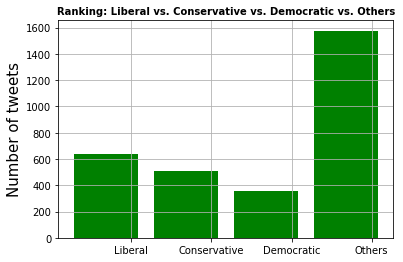

In [34]:
#plot the number of tweets for each political party
parties = ['Liberal', 'Conservative', 'Democratic', 'Others']
tweets_by_parties = [df_unclassified_cleaned['political party'].value_counts()['liberal'], 
                     df_unclassified_cleaned['political party'].value_counts()['conservative'], 
                     df_unclassified_cleaned['political party'].value_counts()['democratic'],
                     df_unclassified_cleaned['political party'].value_counts()['others']]

x_pos = list(range(len(parties)))
width = 0.8
fig, ax = plt.subplots()
plt.bar(x_pos, tweets_by_parties, width, alpha=1, align='center', color='g')

ax.set_ylabel('Number of tweets', fontsize=15)
ax.set_title('Ranking: Liberal vs. Conservative vs. Democratic vs. Others', fontsize=10, fontweight='bold')
ax.set_xticks([p + 0.4 * width for p in x_pos])
ax.set_xticklabels(parties)

plt.grid()

Even though the majorty of tweets are classified to "Others" but it may becuase of the limitation of my keywords that makes some of tweets unable to be correctly identified to a specific party. Moreover, a lot of those "Others" tweets may be totoally irrelevant to the elections meaning has nothing to do with any specific party. So if we ignore this category for now and only consider those tweets with parties have been explicitly identified, we can conclude that more tweets are talking about Liberal party than those about Convervative or Democratic.

I will also plot a WordCloud for unclassfied tweets.

In [35]:
#cast the tweets to strings in a pandas series
df_unclassified_cleaned_str = df_unclassified_cleaned['text'].astype(str)

#put each tweet string into a list
st_list = []
for item in df_unclassified_cleaned_str:
    st_list.append(item)

#join all strings in the list to one whole string to be used for the Wordcloud    
text_string = ''.join(st_list)

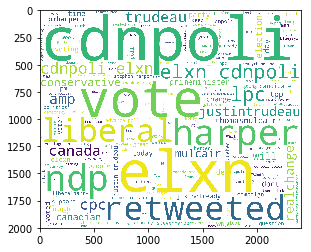

In [36]:
#generate the wordcloud with the string contains all the cleaned tweets
wordcloud = WordCloud(background_color='white', width=2400, height=2000).generate(text_string)

plt.imshow(wordcloud)
plt.axis('on')
plt.show()

Now with unclassfied tweets were cleaned I can go and use the regression model to predict the sentiment values for the unclassfied tweets.

In [37]:
#re-train the model using all the classidied tweets instead of only 70% of them
log_model = LogisticRegression()
log_model = log_model.fit(X=corpus_data_features_nd, y=df_classified_cleaned['class'])

In [38]:
#get the features of the unclassified tweets
unclassified_data_features = vectorizer.fit_transform(df_unclassified_cleaned.text.tolist())

In [39]:
#get predictions using the model and unclassified tweets' features
test_pred = log_model.predict(unclassified_data_features)

In [40]:
#put unclassified tweets together with their predicted sentiment values in a dataframe
results = pd.DataFrame(list(zip(test_pred, df_unclassified_cleaned.text, df_unclassified_cleaned['political party'])), columns=['Sentiment','Text', 'Political Party'])
#display the first 5 rows
results.head()

,Sentiment,Text,Political Party
0,4,living dream cameraman camera cameraception ca...,others
1,0,justin trudeaus reasons thanksgiving todays mo...,liberal
2,0,themadape allergic latex sneeze nbpoli cdnp...,others
3,0,massive explosions peace march turkey killed...,others
4,4,mulcair suggests bad blood trudeau readychan...,liberal


Display logistic regression results together with each tweet's party to see which political party would most likely get the most "positive" votes.

In [41]:
#group all the data in terms of positive/negative sentiment and belonging political party and show the counts
stats = results.groupby(['Sentiment', 'Political Party']).size().reset_index(name='Counts')
stats

,Sentiment,Political Party,Counts
0,0,conservative,261
1,0,democratic,164
2,0,liberal,386
3,0,others,747
4,4,conservative,246
5,4,democratic,190
6,4,liberal,250
7,4,others,829


In [42]:
#show only the positive counts for each political party
positive_feedbacks = stats[stats['Sentiment'] == '4']
positive_feedbacks

,Sentiment,Political Party,Counts
4,4,conservative,246
5,4,democratic,190
6,4,liberal,250
7,4,others,829


In [43]:
#print the totoal political counts for each political party and prepare them for ploting
positive_liberal_count = positive_feedbacks.loc[positive_feedbacks['Political Party'] == 'liberal', 'Counts'].iloc[0]
positive_conservative_count = positive_feedbacks.loc[positive_feedbacks['Political Party'] == 'conservative', 'Counts'].iloc[0]
positive_democratic_count = positive_feedbacks.loc[positive_feedbacks['Political Party'] == 'democratic', 'Counts'].iloc[0]
print (positive_liberal_count, positive_conservative_count, positive_democratic_count)

250 246 190


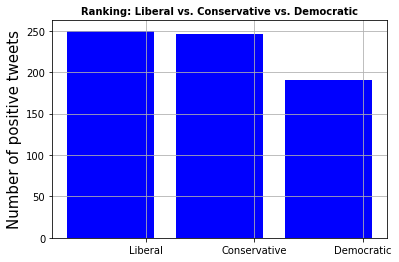

In [44]:
#plot the number of tweets with positive sentiments for each political party
parties = ['Liberal', 'Conservative', 'Democratic']
tweets_by_parties = [positive_liberal_count, 
                     positive_conservative_count, 
                     positive_democratic_count]

x_pos = list(range(len(parties)))
width = 0.8
fig, ax = plt.subplots()
plt.bar(x_pos, tweets_by_parties, width, alpha=1, align='center', color='b')

ax.set_ylabel('Number of positive tweets', fontsize=15)
ax.set_title('Ranking: Liberal vs. Conservative vs. Democratic', fontsize=10, fontweight='bold')
ax.set_xticks([p + 0.4 * width for p in x_pos])
ax.set_xticklabels(parties)

plt.grid()

More people are more likely to vote for liberal party comparing to the other two.

### Naive Bayes Classification
I will use Naive Bayes Mutinomial classification to train and test the model.

In [89]:
#retrieve the original cleaned classfied tweets in a dataframe
df_classified_cleaned.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda david carr third day
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cant update facebook texting cry result...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived times ball managed save rest bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,body feels itchy fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad cant


In [90]:
#import Naive Bayes necessary packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import naive_bayes

In [91]:
#initialize the vectorizer
vectorizer = TfidfVectorizer()

In [92]:
#split the classfied tweets to 70% as training sets.
#X are the features extracted from tweets, y are the targeting sentiment values
X_train, X_test, y_train, y_test  = train_test_split(vectorizer.fit_transform (df_classified_cleaned.text), 
                                                     df_classified_cleaned['class'], 
                                                     train_size=0.70,
                                                     random_state = 42)

In [93]:
#initialize naive bayes mutinomial classification
naive_model = naive_bayes.MultinomialNB()
#fit the model
naive_model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [94]:
#predict the results using the model and test set
y_pred = naive_model.predict(X_test)

In [95]:
#print precision report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.72      0.75      0.73     29851
          4       0.74      0.71      0.72     30149

avg / total       0.73      0.73      0.73     60000



Comparing to logistic regression, precision for 0 is a little lower but precision for 4 is higher but the overall precision and recall rate are the same 73% for both logistic regression model and the naive bayes multinomial classification.

## Final Discussion

The major political parties that people talke about on Twitter are Liberal, Conservative and NDP. Even though there were limitations on the key words I used to determine the possible political party that each Tweet may belong to, the results are still pretty good in terms of the rate of successfully identifying most of tweets. Moreover, a lot of those "Others" tweets may be totoally irrelevant to the elections meaning has nothing to do with any specific party. So I can safely ignore that categoty but only concentrate on the tweets that have been clearly identified to a specific political party. Among those, Liberal is the leading party that has the majoirity of people talking about followed by Conservative and then NDP.

After evaluating the sentiment of each tweets, among those tweets that have potilical party identified, Liberal still has the most of posititve as well as negative responses and then followed by Conservative and NDP. 

250 positive tweets and 386 negative tweets for Liberal.

246 positive tweets and 261 negative tweets for Conservative.

190 positive tweets and 164 negative tweets for NDP.

Both Liberal and Conservative have more negative tweets than positive tweets, while there were more positive tweets and nagative tweets. It seems people like to complain on those political parties a lot. Even thought positive tweets for NDP out numbers its negative tweets, if we only look at the number of posititve tweets for each party, Liberal still have the majority of postitive tweets so Liberal is more popular.

Now looking back at the actual election results back in 2015 which Liberal party won and comparing to this sentiment analysis results from the tweets that were twitted back then, one can clearly see the sentiment results could have given a very good predicition in which Liberal Party would win the election. Though both my regreesion model and Naive Bayes model only have a precision of 73%, they still produced very good results overall.